In [1]:
import phippery
from phippery.utils import *

import xarray as xr
import numpy as np
import pandas as pd

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import warnings
warnings.filterwarnings('ignore')

import logomaker

In [2]:
phip_file = 'LK_DMS_1rep_layered.phip'     # input file
metric    = "smooth_flank_1_enr_diff_sel"  # scaled differential selection name

# epitope region position boundaries
epitope_limits = {
    "FP"  : [ 805,  835],
    "SHH" : [1135, 1170]
}
epitope_names = {
    "FP"  : "FP",
    "SHH" : "SH-H"
}

# output directory
outdir = 'results'
if not os.path.exists(outdir): os.mkdir(outdir)

# Okabe-Ito colors
oi_black         = '#000000'
oi_orange        = '#E69F00'
oi_skyblue       = '#56B4E9'
oi_bluishgreen   = '#009E73'
oi_yellow        = '#F0E442'
oi_blue          = '#0072B2'
oi_vermillion    = '#D55E00'
oi_reddishpurple = '#CC79A7'    

ds = phippery.load(phip_file)

In [3]:
# infant data subset
lk_infant_sams = sample_id_coordinate_subset(ds,where='sample_group',is_equal_to='LK African Infant').tolist()
lk_infant_ds = ds.loc[dict(sample_id=lk_infant_sams)]
lk_infant_ds

<xarray.Dataset>
Dimensions:                      (peptide_id: 24840, peptide_metadata: 6, sample_id: 10, sample_metadata: 31)
Coordinates:
  * peptide_id                   (peptide_id) int64 0 1 2 ... 24837 24838 24839
  * sample_id                    (sample_id) int64 1461 1421 1432 ... 1416 1468
  * sample_metadata              (sample_metadata) object 'Cohort' ... 'visit...
  * peptide_metadata             (peptide_metadata) object 'Oligo' ... 'is_wt'
Data variables:
    counts                       (peptide_id, sample_id) int64 0 0 0 ... 7 261
    sample_table                 (sample_id, sample_metadata) object nan ... nan
    peptide_table                (peptide_id, peptide_metadata) object 'aggaa...
    cpm                          (peptide_id, sample_id) float64 0.0 ... 233.9
    size_factors                 (peptide_id, sample_id) float64 0.0 ... 125.1
    enrichment                   (peptide_id, sample_id) float64 0.1664 ... 1.39
    neg_binom_mlxp               (peptide_id, sample_id) float64 0.0 ... 0.593
    smooth_flank_1_enr_diff_sel  (peptide_id, sample_id) float64 0.4527 ... 0...
Attributes:
    collapsed_variable:  None

In [4]:
# mother data subset
lk_mother_sams = sample_id_coordinate_subset(ds,where='sample_group',is_equal_to='LK African Mother').tolist()
lk_mother_ds = ds.loc[dict(sample_id=lk_mother_sams)]
lk_mother_ds

<xarray.Dataset>
Dimensions:                      (peptide_id: 24840, peptide_metadata: 6, sample_id: 35, sample_metadata: 31)
Coordinates:
  * peptide_id                   (peptide_id) int64 0 1 2 ... 24837 24838 24839
  * sample_id                    (sample_id) int64 1422 1423 1424 ... 1467 1420
  * sample_metadata              (sample_metadata) object 'Cohort' ... 'visit...
  * peptide_metadata             (peptide_metadata) object 'Oligo' ... 'is_wt'
Data variables:
    counts                       (peptide_id, sample_id) int64 0 0 ... 71 1270
    sample_table                 (sample_id, sample_metadata) object nan ... nan
    peptide_table                (peptide_id, peptide_metadata) object 'aggaa...
    cpm                          (peptide_id, sample_id) float64 0.0 ... 1.35...
    size_factors                 (peptide_id, sample_id) float64 0.0 ... 1.04...
    enrichment                   (peptide_id, sample_id) float64 0.1664 ... 8...
    neg_binom_mlxp               (peptide_id, sample_id) float64 0.0 ... 3.37
    smooth_flank_1_enr_diff_sel  (peptide_id, sample_id) float64 0.2716 ... -...
Attributes:
    collapsed_variable:  None

In [5]:
def make_plot(
    ds,
    partIDs,        # specify participant IDs for logo plots
    epitope_region, # epitope region name
    color,          # color for summed scaled differential selection boxplot
    ymin=0,
    ymax=0,
    draw=True,
    out=None
):
    h_logo = 1.5
    h_sum = 3
    heights = len(partIDs)*[h_logo] + [h_sum]
    
    fig = plt.figure(figsize=[12,h_logo*len(partIDs)+h_sum])
    fig.patch.set_facecolor('white')
    gs = fig.add_gridspec(len(partIDs)+1, height_ratios=heights)
    axs = gs.subplots(sharex=False, sharey=False)
    
    loc_start = epitope_limits[epitope_region][0]
    loc_end   = epitope_limits[epitope_region][1]
    
    xticks=[]
    xlabels=[]
    for i in range(loc_end - loc_start + 1):
        label = loc_start+i
        if label%5 == 0:
            xticks.append(i+1)
            xlabels.append(label)
            
    title = f'{epitope_names[epitope_region]}: [{loc_start}, {loc_end}]'
    fig.suptitle(title, fontsize=24, y=1)

    epitope_pids = peptide_id_coordinate_subset(ds,
                                                where='Loc',
                                                is_in=np.arange(loc_start, loc_end+1)
                                               )
        
    # logo plots for specified participant IDs
    for i in range(len(partIDs)):
        partID = partIDs[i]
        sid = sample_id_coordinate_subset(ds,'participant_ID',is_equal_to=partID).item()
        sample_ds = ds.loc[dict(sample_id=sid, peptide_id=epitope_pids)]
        
        row_indices = np.arange(1, loc_end-loc_start+2)
        col_indices = sorted(list(set(sample_ds.peptide_table.loc[:,'aa_sub'].values.tolist())))
        
        sample_df = pd.DataFrame(0., index=row_indices, columns=col_indices)
        for pid in sample_ds.peptide_id.values:
            [ploc, aa_sub] = sample_ds.peptide_table.loc[pid, ['Loc', 'aa_sub']].values
            val = sample_ds[metric].loc[pid].values
            sample_df.at[ploc - loc_start + 1, aa_sub] = val
        
        logomaker.Logo(sample_df,
                       ax=axs[i],
                       vpad=0.05,
                       color_scheme='chemistry',
                       show_spines=False,
                       flip_below=False)
        axs[i].label_outer()
        axs[i].locator_params(axis='y', nbins=2)
        axs[i].set_xticks([])
        plt.setp(axs[i].get_xticklabels(), fontsize=20)
        plt.setp(axs[i].get_yticklabels(), fontsize=16)
        
    # summed scaled differential selection boxplots
    region_sums=[]
    for loc in range(loc_start, loc_end+1):    
        loc_sums=[]
        for sid in ds.sample_id.values:
            pids = peptide_id_coordinate_subset(ds,where='Loc',is_equal_to=loc)
            sample_loc_ds = ds.loc[dict(sample_id=sid, peptide_id=pids)]
            scaled_diff_sel = sample_loc_ds[metric].to_pandas().to_numpy().flatten()
            loc_sums.append(np.sum(scaled_diff_sel))
            
        region_sums.append(loc_sums)
    
    linew=2
    axs[-1].boxplot(region_sums,
                    sym='',
                    boxprops=dict(color=color, linewidth=linew),
                    whiskerprops=dict(color=color, linewidth=0),
                    capprops=dict(color=color, linewidth=0),
                    medianprops=dict(color=color, linewidth=linew, linestyle='-')
                   )
    axs[-1].axhline(color='gray',linestyle=':')
    axs[-1].set_xlabel("Amino Acid Position", fontsize=24, labelpad=10)
    axs[-1].set_ylabel('Summed Scaled\nDifferential Selection', fontsize=20, labelpad=10)
    axs[-1].set_xticks(xticks)
    axs[-1].set_xticklabels(xlabels)
    plt.setp(axs[-1].get_xticklabels(), fontsize=20)
    plt.setp(axs[-1].get_yticklabels(), fontsize=14)
    if ymin!=ymax:
        axs[-1].set_ylim(ymin=ymin,ymax=ymax)
    
    plt.tight_layout()
    
    if out:
        plt.savefig(out)
        outf = open(f"{out[:-4]}.csv", "w")
        outf.write('loc,sum_scaled_diff_sel,participant_ID\n')
        for iloc,sums in zip(range(len(region_sums)),region_sums):
            for val, pid in zip(sums, partIDs):
                outf.write(f'{iloc+loc_start},{val},{pid}\n')
        outf.close()
        
    if draw:
        plt.show()
    else:
        plt.close(fig)

In [6]:
def plot_logo_column(
    ds,
    partIDs,        # specify participant IDs for logo plots
    epitope_region, # epitope region name
    draw=True,
    out=None
):
    h_logo = 1.5
    
    fig = plt.figure(figsize=[12,h_logo*len(partIDs)])
    fig.patch.set_facecolor('white')
    gs = fig.add_gridspec(len(partIDs))
    axs = gs.subplots(sharex=False, sharey=False)
    
    loc_start = epitope_limits[epitope_region][0]
    loc_end   = epitope_limits[epitope_region][1]    
    
    xticks=[]
    xlabels=[]
    for i in range(loc_end - loc_start + 1):
        label = loc_start+i
        if label%5 == 0:
            xticks.append(i+1)
            xlabels.append(label)
            
    title = f'{epitope_names[epitope_region]}: [{loc_start}, {loc_end}]'
    fig.suptitle(title, fontsize=24, y=1)

    epitope_pids = peptide_id_coordinate_subset(ds,
                                                where='Loc',
                                                is_in=np.arange(loc_start, loc_end+1)
                                               )
    
    # logo plots for specified participant IDs
    for i in range(len(partIDs)):
        partID = partIDs[i]
        sid = sample_id_coordinate_subset(ds,'participant_ID',is_equal_to=partID).item()
        sample_ds = ds.loc[dict(sample_id=sid, peptide_id=epitope_pids)]
        
        row_indices = np.arange(1, loc_end-loc_start+2)
        col_indices = sorted(list(set(sample_ds.peptide_table.loc[:,'aa_sub'].values.tolist())))
        
        sample_df = pd.DataFrame(0., index=row_indices, columns=col_indices)
        for pid in sample_ds.peptide_id.values:
            [ploc, aa_sub] = sample_ds.peptide_table.loc[pid, ['Loc', 'aa_sub']].values
            val = sample_ds[metric].loc[pid].values
            sample_df.at[ploc - loc_start + 1, aa_sub] = val
        
        logomaker.Logo(sample_df,
                       ax=axs[i],
                       vpad=0.05,
                       color_scheme='chemistry',
                       show_spines=True,
                       flip_below=False)
        axs[i].label_outer()
        axs[i].locator_params(axis='y', nbins=2)
        axs[i].set_xticks([])
        plt.setp(axs[i].get_xticklabels(), fontsize=20)
        plt.setp(axs[i].get_yticklabels(), fontsize=16)
    
    axs[-1].set_xlabel("Amino Acid Position", fontsize=24, labelpad=10)
    axs[-1].set_xticks(xticks)
    axs[-1].set_xticklabels(xlabels)
    plt.setp(axs[-1].get_xticklabels(), fontsize=20)
    
    plt.tight_layout()
    
    if out:
        plt.savefig(out)
        
    if draw:
        plt.show()
    else:
        plt.close(fig)

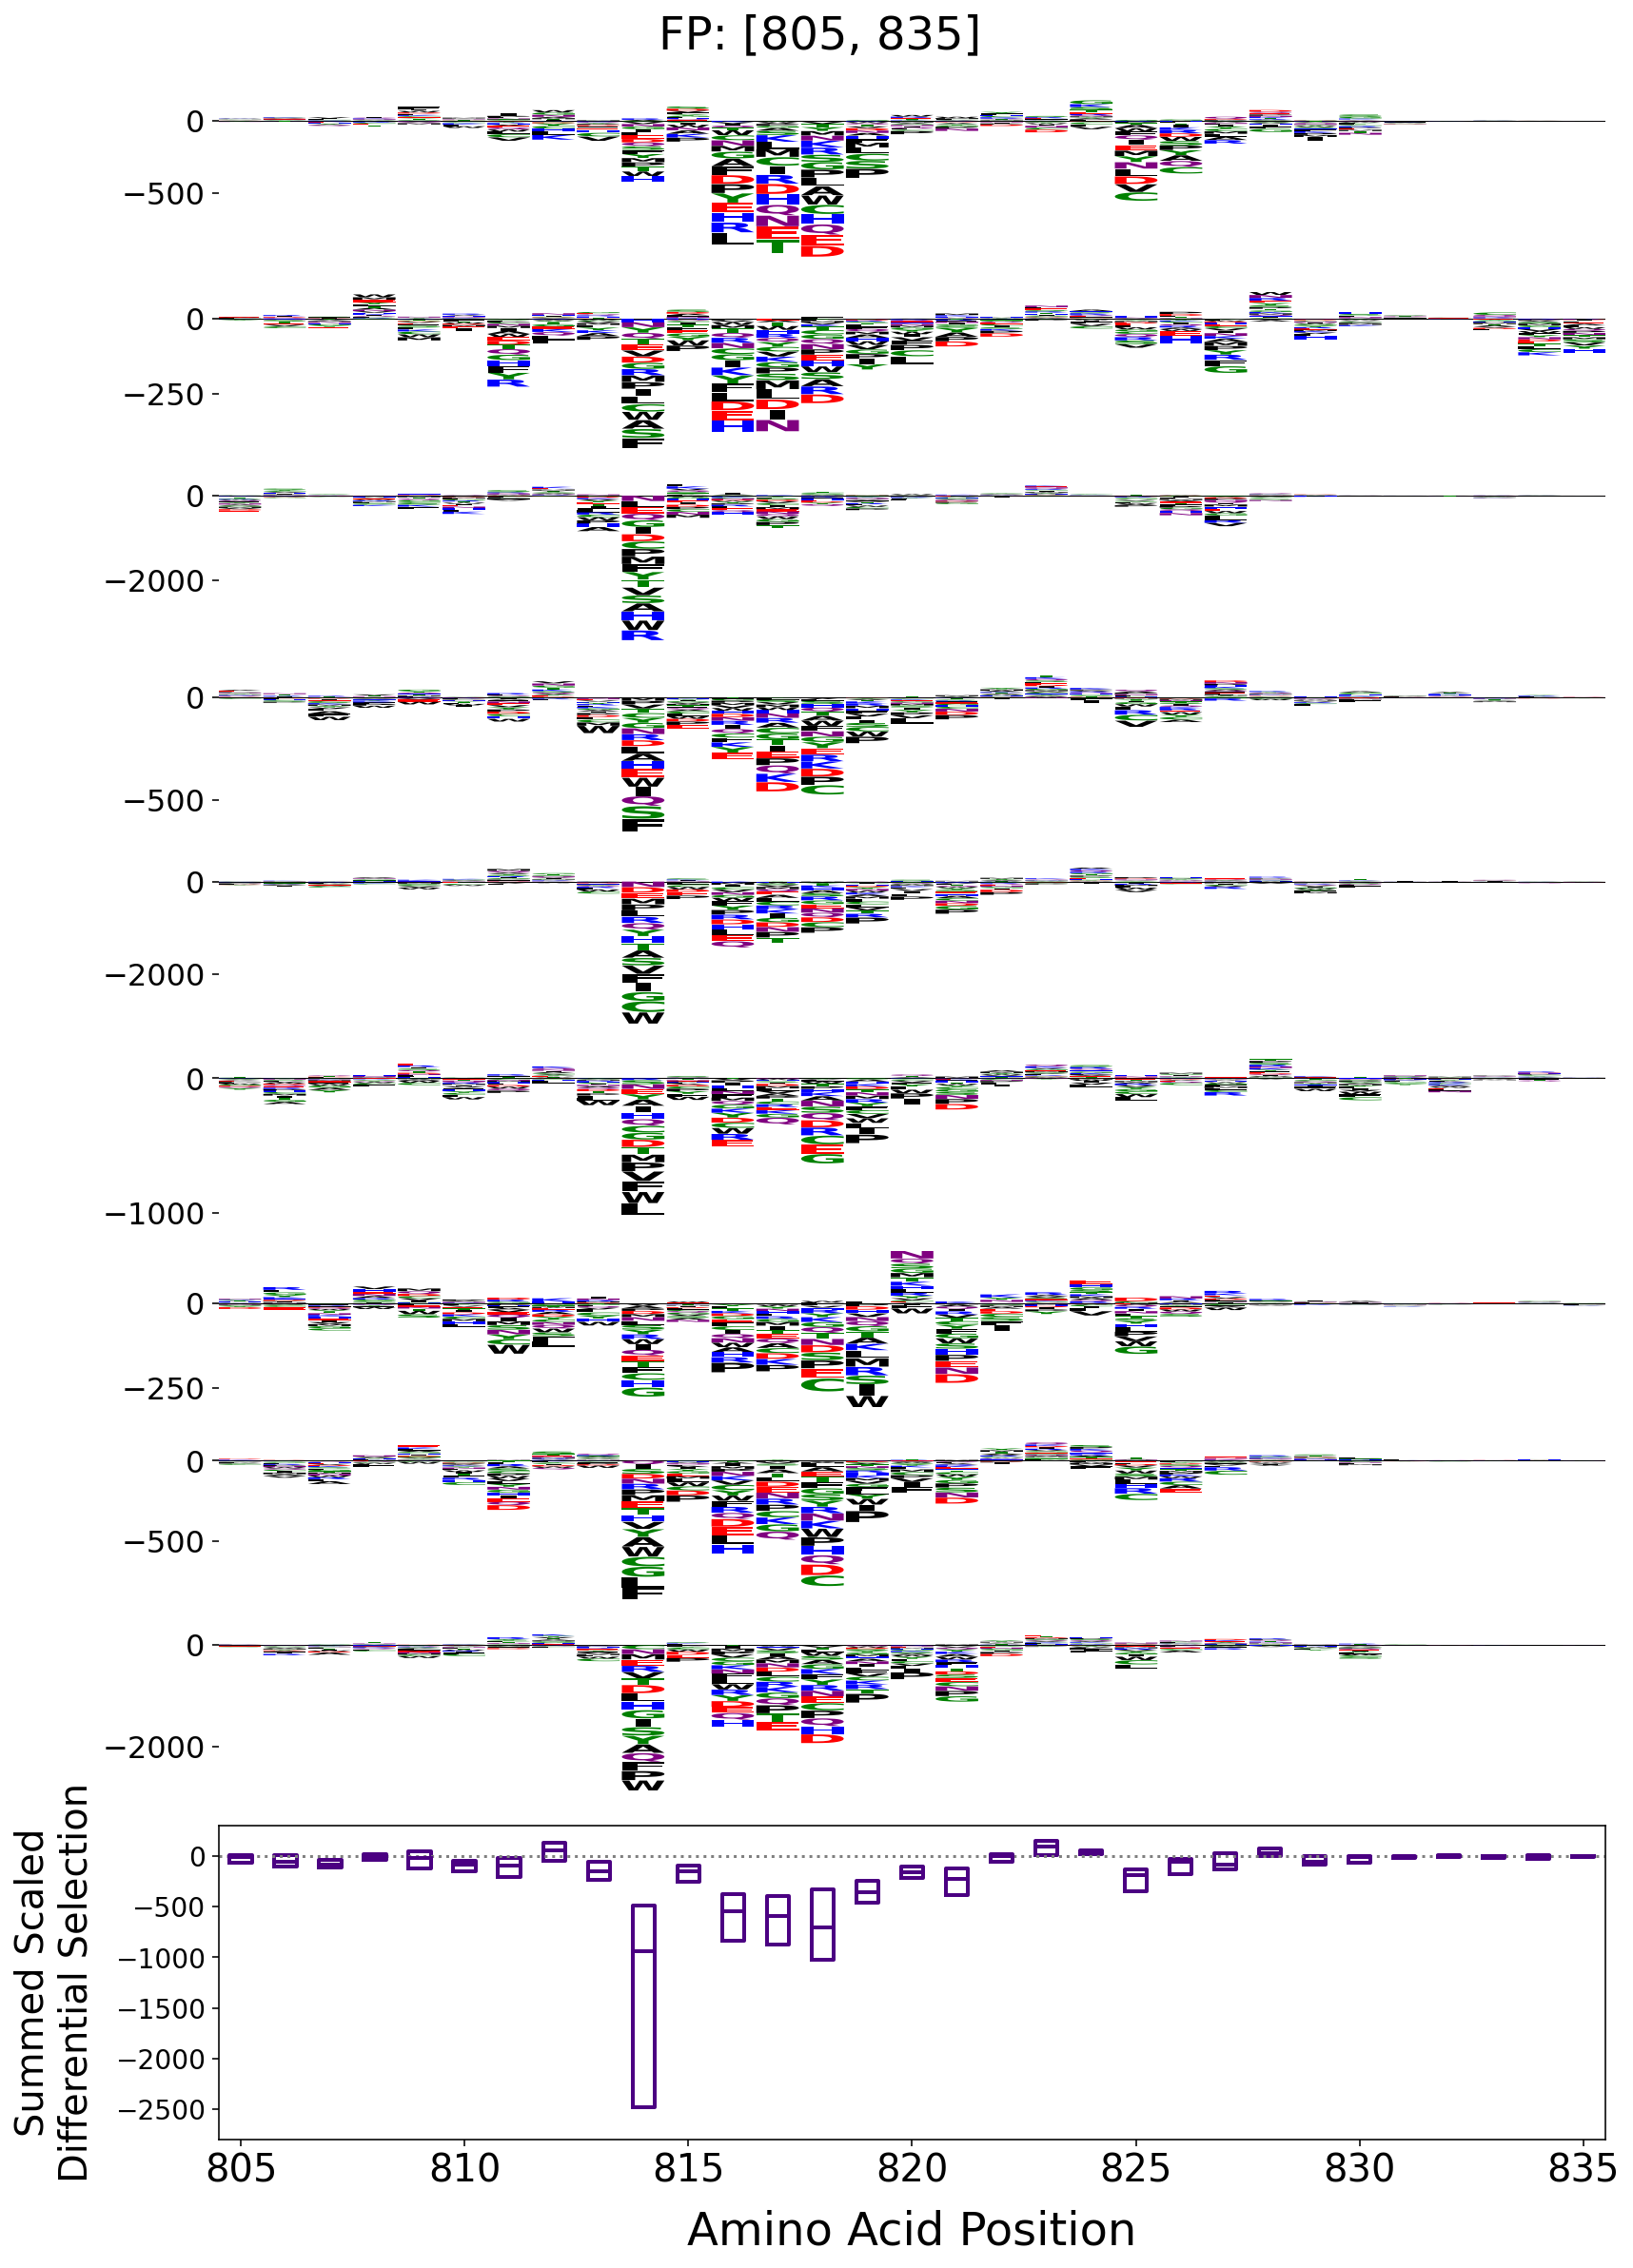

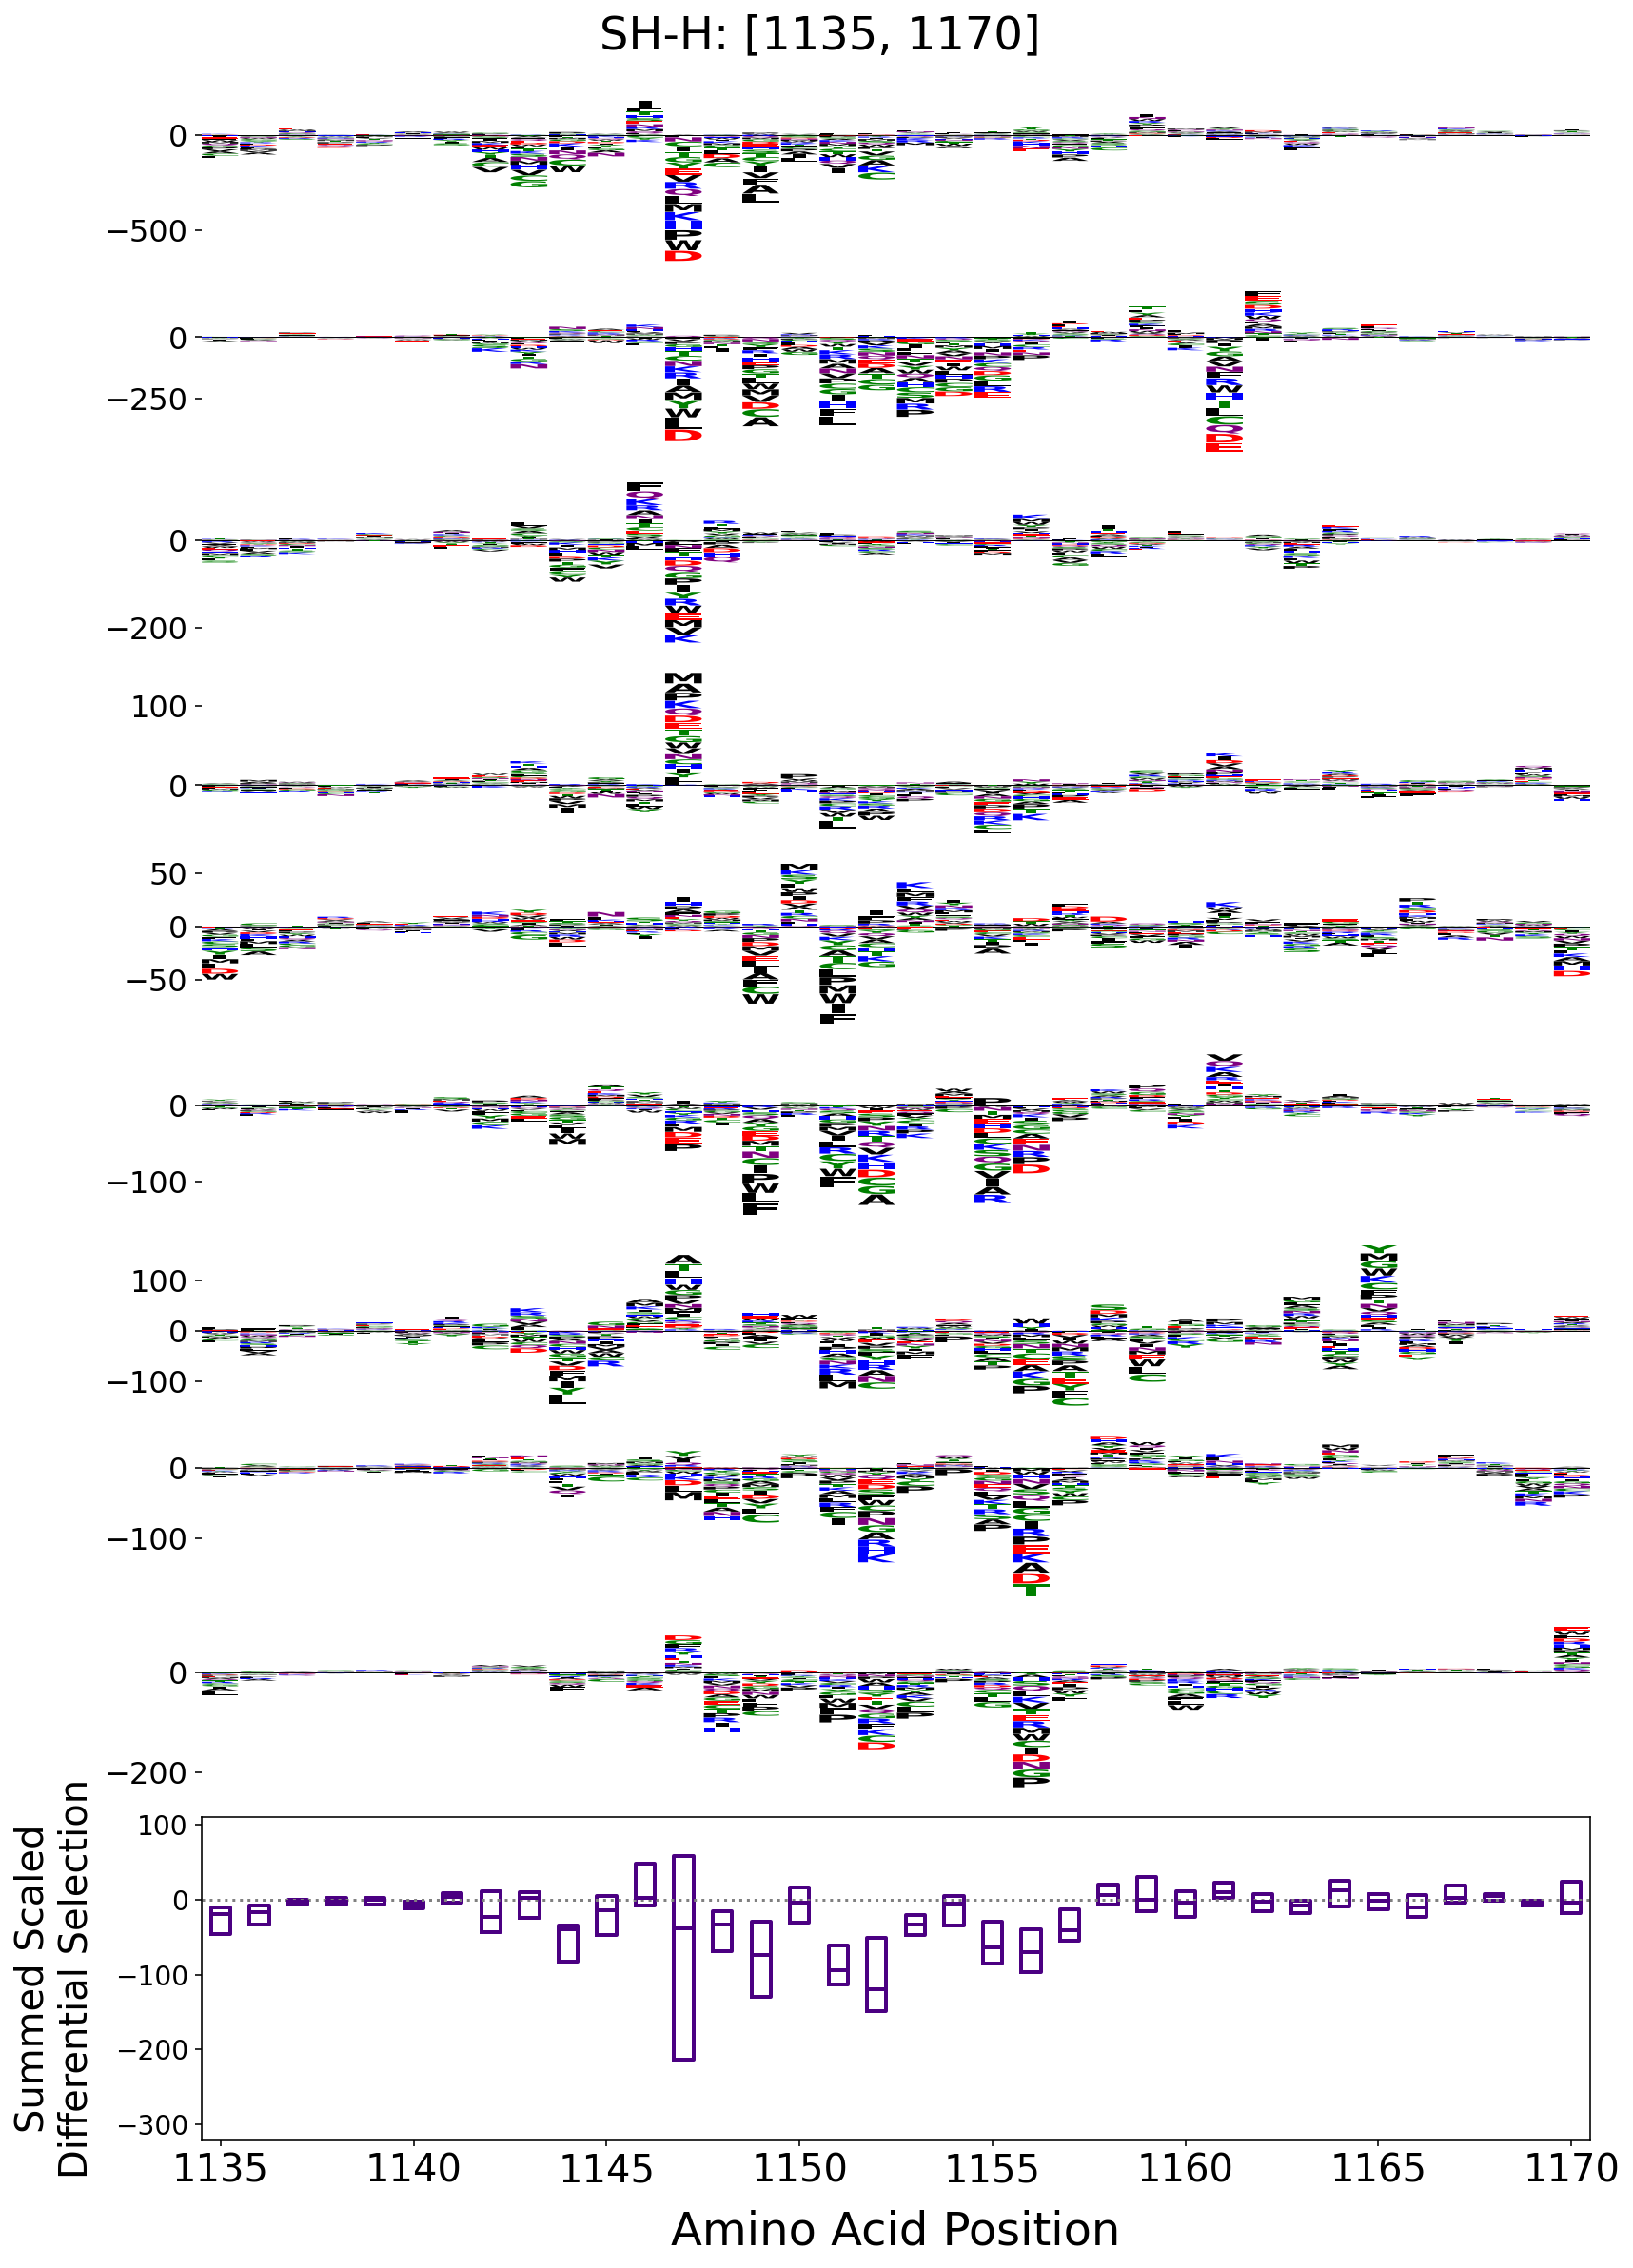

In [7]:
infant_partIDs = [  'ptnum_8',  'ptnum_18',  'ptnum_25',  'ptnum_41',  'ptnum_50', 
                  'ptnum_142', 'ptnum_169', 'ptnum_185', 'ptnum_186']

make_plot(lk_infant_ds,infant_partIDs,'FP','indigo',ymin=-2800,ymax=300,draw=True,out=f'{outdir}/infants_FP_logo_diff_sel.pdf')
make_plot(lk_infant_ds,infant_partIDs,'SHH','indigo',ymin=-320,ymax=110,draw=True,out=f'{outdir}/infants_SHH_logo_diff_sel.pdf')

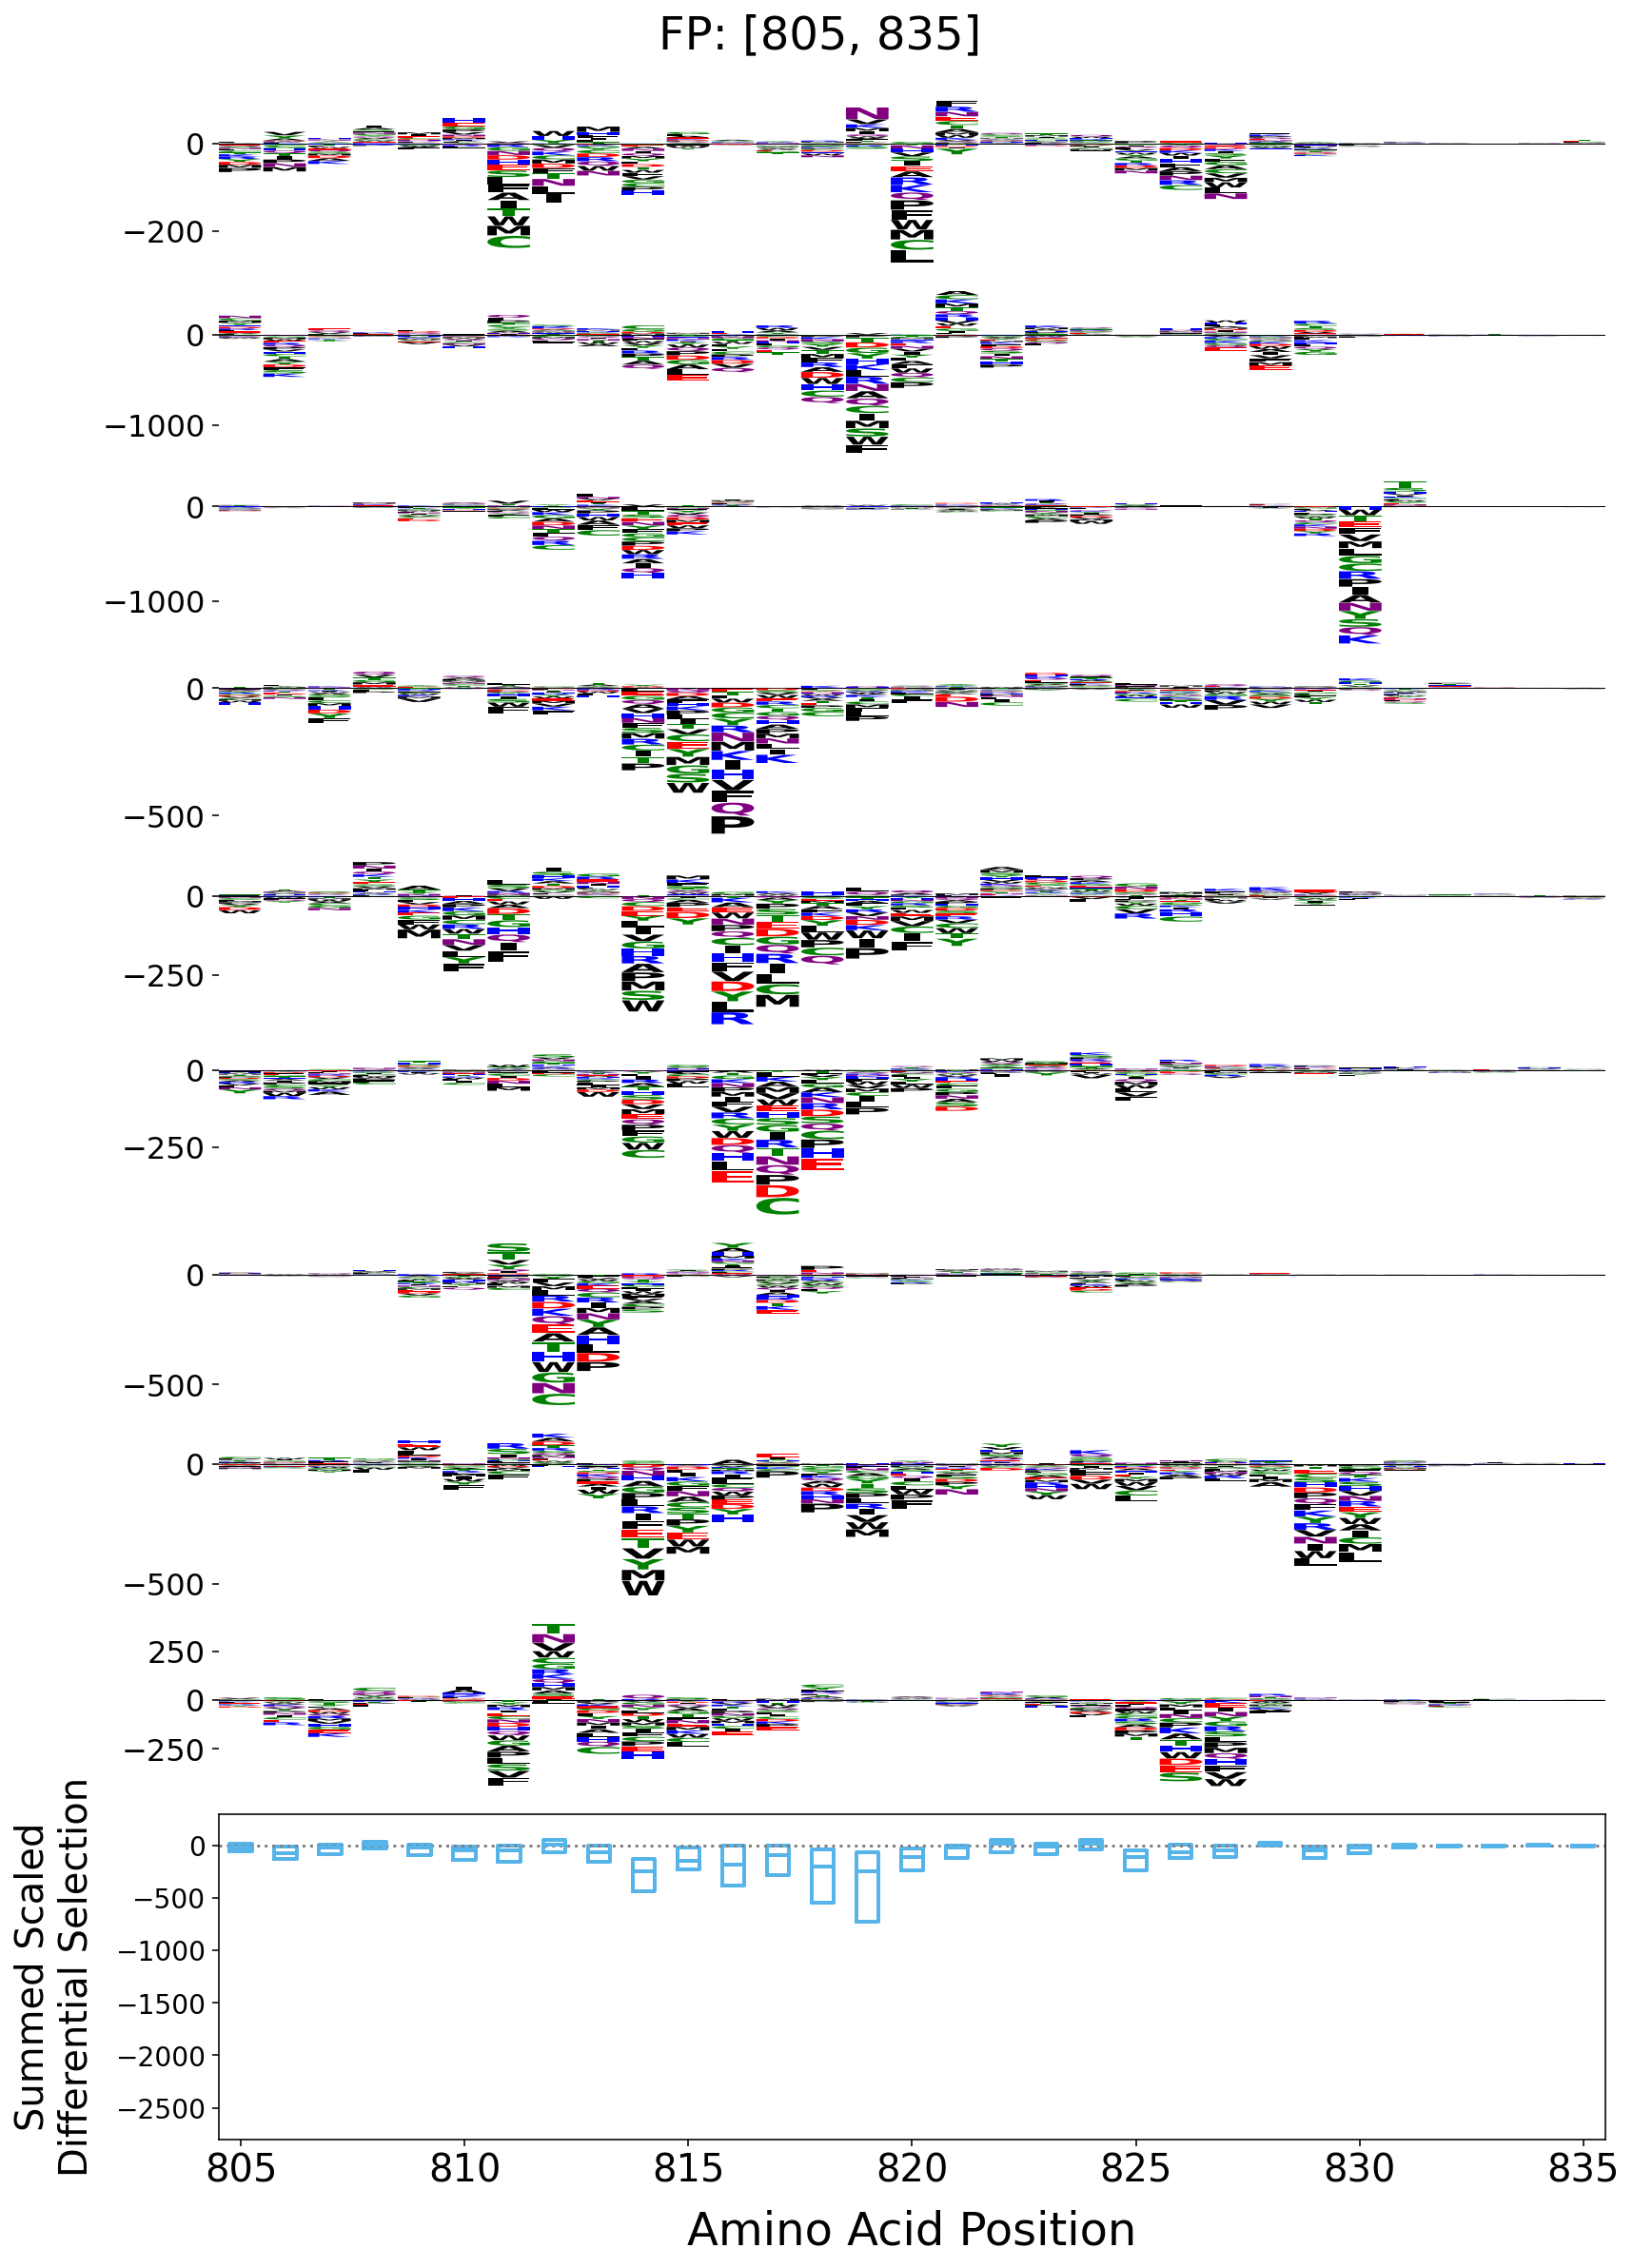

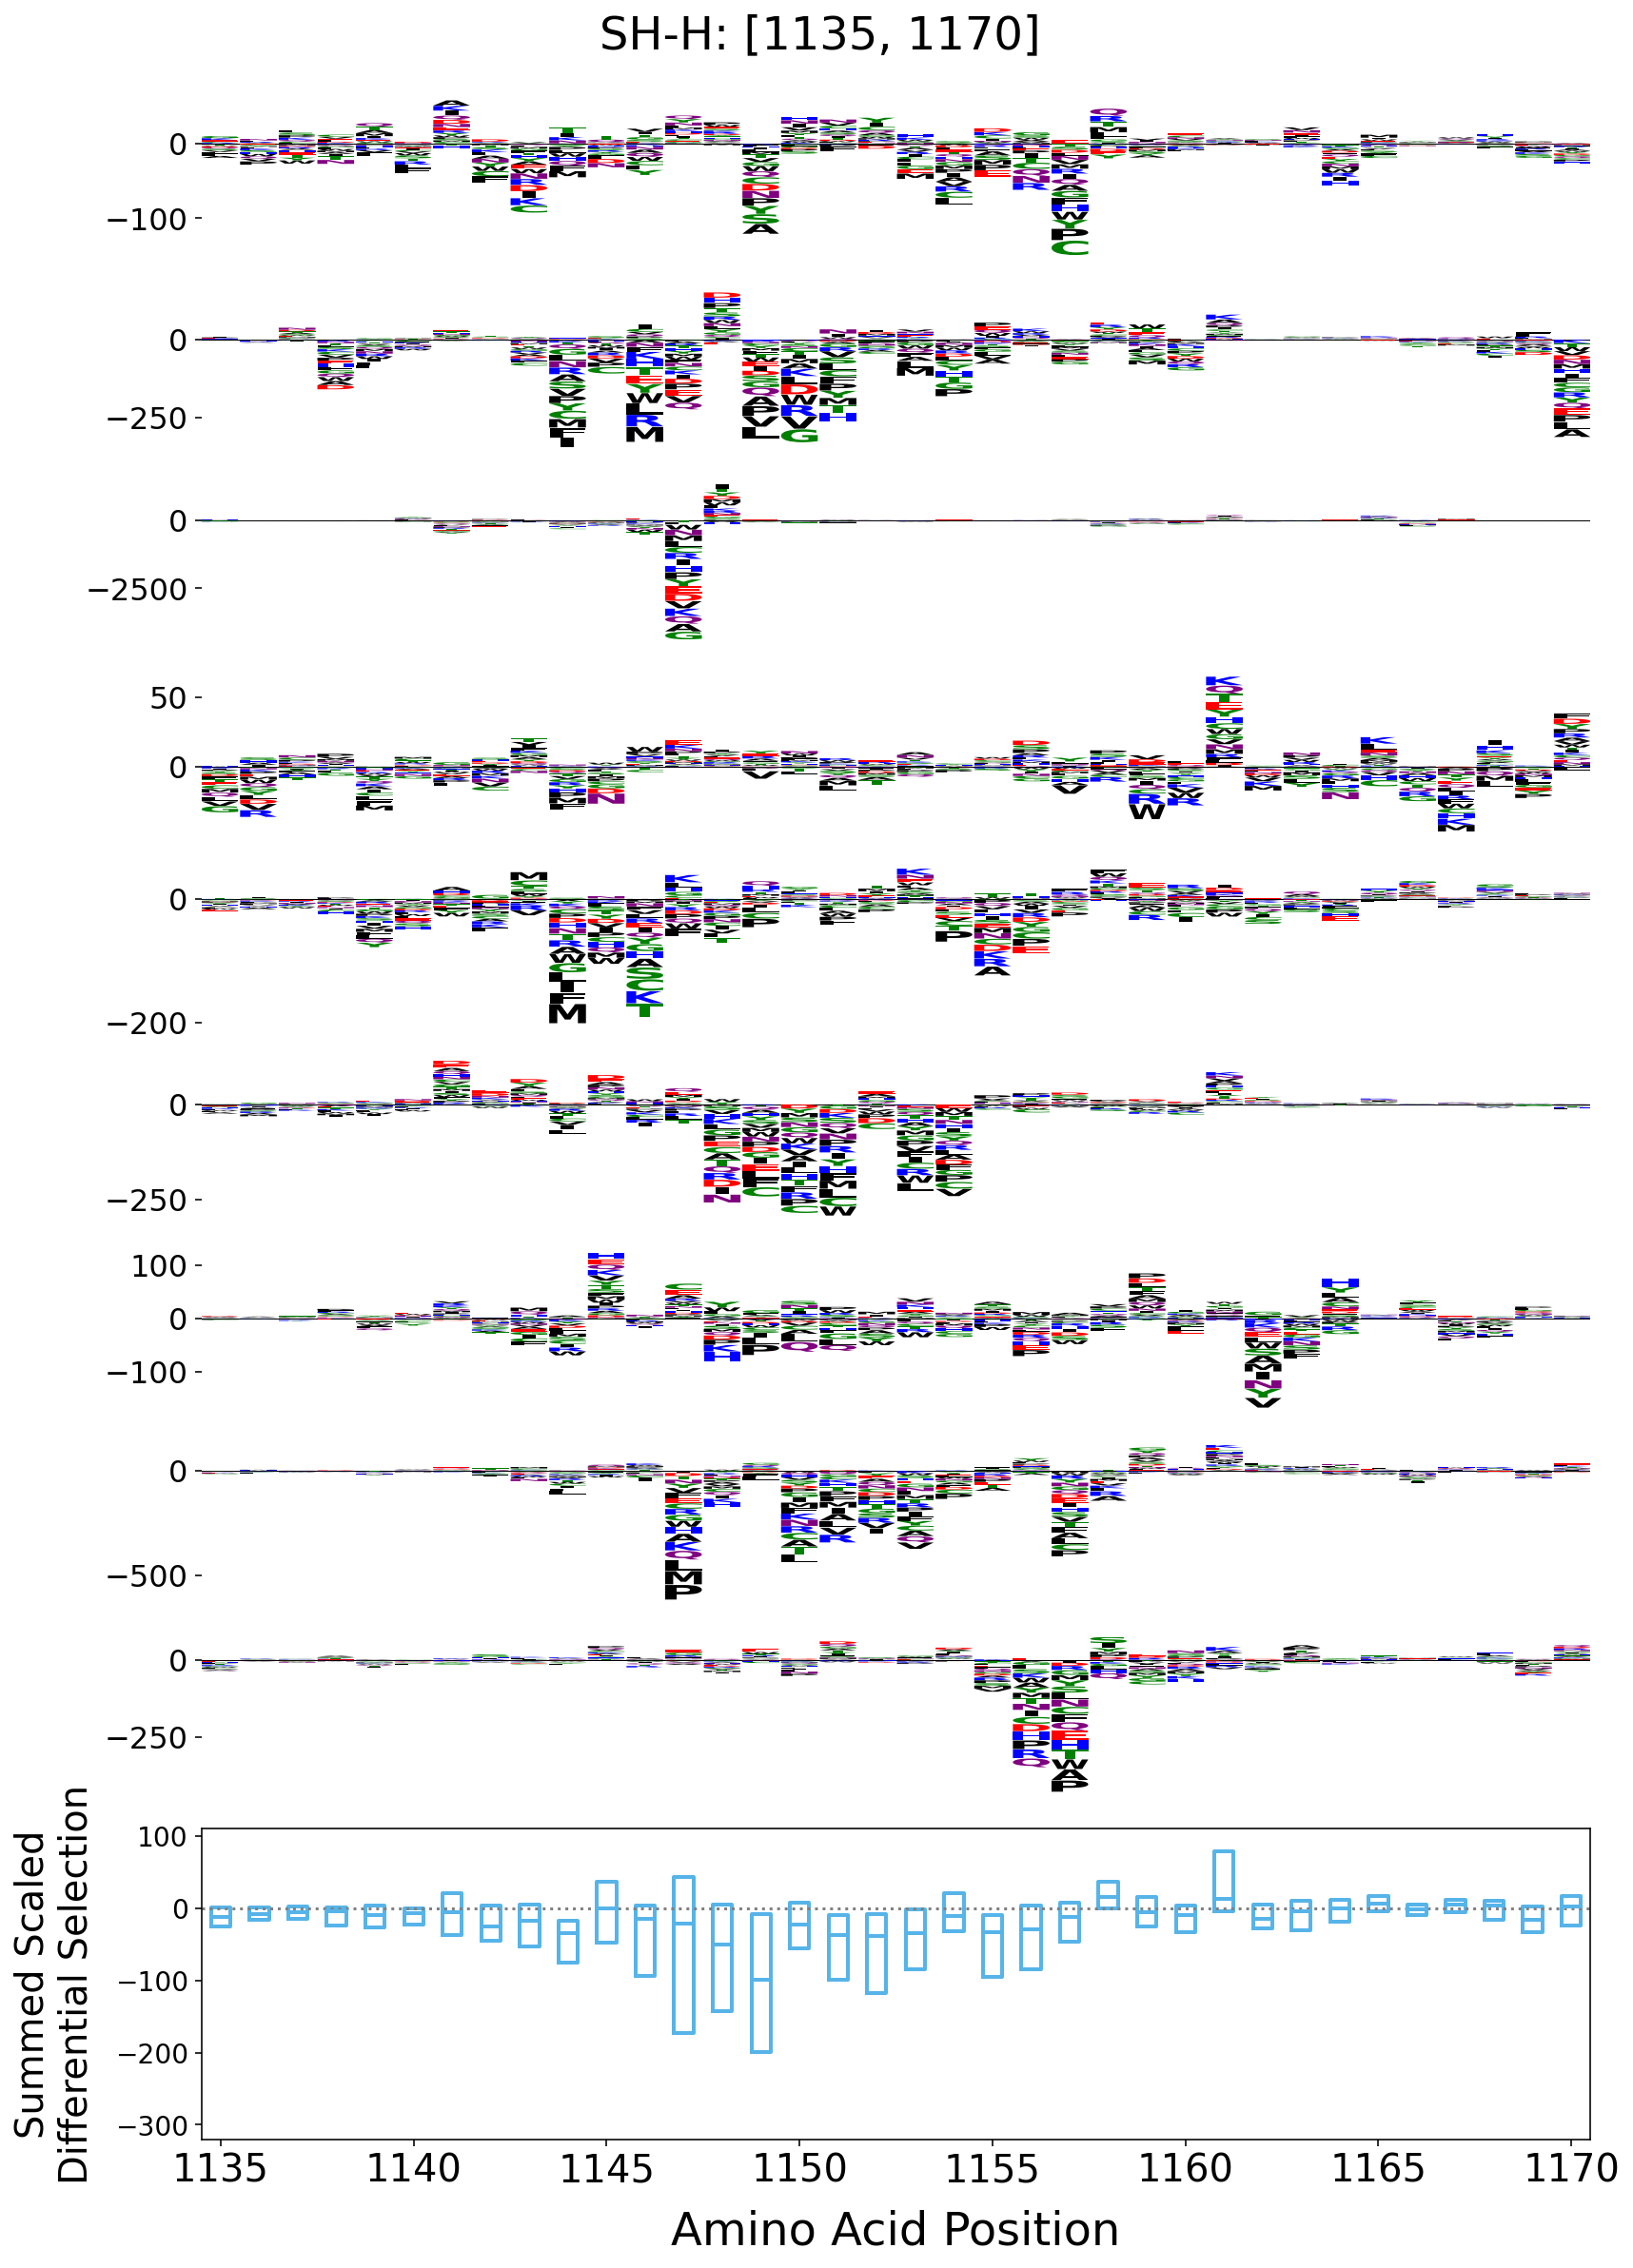

In [8]:
mother_partIDs = [  'ptnum_8',  'ptnum_18',  'ptnum_25',  'ptnum_41',  'ptnum_50', 
                  'ptnum_142', 'ptnum_169', 'ptnum_185', 'ptnum_186']

make_plot(lk_mother_ds,mother_partIDs,'FP',oi_skyblue,ymin=-2800,ymax=300,draw=True,out=f'{outdir}/mothers_FP_logo_diff_sel.pdf')
make_plot(lk_mother_ds,mother_partIDs,'SHH',oi_skyblue,ymin=-320,ymax=110,draw=True,out=f'{outdir}/mothers_SHH_logo_diff_sel.pdf')

In [9]:
mother_supp1 = [
     'ptnum_27',  'ptnum_75',  'ptnum_79', 'ptnum_101', 'ptnum_105', 'ptnum_106',
    'ptnum_111', 'ptnum_112', 'ptnum_115', 'ptnum_132', 'ptnum_139', 'ptnum_146',
    'ptnum_149'
]
plot_logo_column(lk_mother_ds, mother_supp1, 'FP', draw=False, out=f'{outdir}/mothers_FP_logo_supp1.pdf')
plot_logo_column(lk_mother_ds, mother_supp1, 'SHH', draw=False, out=f'{outdir}/mothers_SHH_logo_supp1.pdf')

In [10]:
mother_supp2 = [
    'ptnum_155', 'ptnum_166', 'ptnum_168', 'ptnum_172', 'ptnum_183', 'ptnum_189',
    'ptnum_194', 'ptnum_199', 'ptnum_200', 'ptnum_202', 'ptnum_203', 'ptnum_204',
    'ptnum_205'
]
plot_logo_column(lk_mother_ds, mother_supp2, 'FP', draw=False, out=f'{outdir}/mothers_FP_logo_supp2.pdf')
plot_logo_column(lk_mother_ds, mother_supp2, 'SHH', draw=False, out=f'{outdir}/mothers_SHH_logo_supp2.pdf')